In [0]:
#Please re-run if it crashes

%matplotlib inline
import matplotlib.pyplot as plt

import numpy
import numpy as np
from google.colab import drive

from scipy.stats import norm

#import tensorflow as tf

import keras
from keras.layers import Lambda
from keras import layers
from keras.models import Model
from keras import metrics
from keras import backend as K   # 'generic' backend so code works with either tensorflow or theano

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [26]:
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [0]:
# dimensions of our images.
img_width, img_height = 250, 250

train_data_dir = '/content/drive/My Drive/Colab Notebooks/data/unaugmented/train'
validation_data_dir = '/content/drive/My Drive/Colab Notebooks/data/unaugmented/validation'
nb_train_samples = 1727
nb_validation_samples = 113
epochs = 5
batch_size = 16

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

#input_shape = Lambda(lambda x: tf.image.rgb_to_grayscale(x))
def gray_scale_conversion(x):
    import tensorflow as tf    
    return tf.image.rgb_to_grayscale(x)

model = Sequential()
model.add(Lambda(gray_scale_conversion, input_shape=(250, 250, 3)))
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

In [0]:
model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(128))
model.add(Activation('relu'))
#model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))
#model.add(Dense(1))
#model.add(Activation('tanh'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

#model.compile(loss='squared_hinge',
              #optimizer='rmsprop',
              #metrics=['accuracy'])

In [29]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rotation_range=0,
        #zca_whitening=True,
        #featurewise_center=True,
        #featurewise_std_normalization=True,
        #width_shift_range=0.2,
        #height_shift_range=0.2,
        rescale=1./255,
        #shear_range=0.2,
        #zoom_range=0.2,
        horizontal_flip=False)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolders of 'data/train_data_dir', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        train_data_dir,  # this is the target directory
        target_size=(img_width, img_height),  # all images remain at 250x250
        #color_mode='grayscale',
        batch_size=batch_size,
        #save_to_dir='/content/drive/My Drive/Colab Notebooks/data/augmented/train/bush', 
        #save_prefix='new', 
        #save_format='jpeg',
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary')


Found 1727 images belonging to 2 classes.
Found 113 images belonging to 2 classes.


In [30]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=nb_validation_samples // batch_size)

model.save_weights('/content/drive/My Drive/Colab Notebooks/faceWeights4.h5')  # always save your weights after training or during training

Epoch 1/5
107/107 [==============================] - 5s 45ms/step - loss: 0.6075 - acc: 0.7266 - val_loss: 0.7166 - val_acc: 0.5536
Epoch 2/5
107/107 [==============================] - 5s 43ms/step - loss: 0.5216 - acc: 0.7450 - val_loss: 0.7843 - val_acc: 0.5670
Epoch 3/5
107/107 [==============================] - 4s 42ms/step - loss: 0.4158 - acc: 0.8142 - val_loss: 0.4064 - val_acc: 0.8041
Epoch 4/5
107/107 [==============================] - 5s 43ms/step - loss: 0.2837 - acc: 0.8773 - val_loss: 0.3431 - val_acc: 0.8763
Epoch 5/5
107/107 [==============================] - 4s 42ms/step - loss: 0.1934 - acc: 0.9164 - val_loss: 0.1965 - val_acc: 0.9175


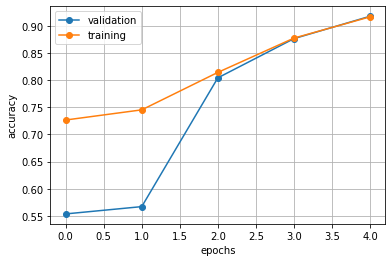

In [31]:

plt.plot(history.epoch,history.history['val_acc'],'-o',label='validation')
plt.plot(history.epoch,history.history['acc'],'-o',label='training')

plt.legend(loc=0)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.grid(True)

In [32]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy

test_data_dir = '/content/drive/My Drive/Colab Notebooks/data/unaugmented/test'
test_datagen = ImageDataGenerator(rescale=1./255)

#batch_input = np.zeros((1,) + (250, 250, 3), dtype=K.floatx())
#img_input = img_to_array(load_img(test_data_dir))
#batch_input[0] = img_input

#test_data_dir = test_data_dir.reshape(img_width, img_height)
test_generator = test_datagen.flow_from_directory(
        #batch_input,
        test_data_dir,
        target_size=(img_width, img_height),
        #color_mode="grayscale",
        shuffle = False,
        class_mode='categorical',
        batch_size=1)

filenames = test_generator.filenames
nb_samples = len(filenames)

predict = model.predict_generator(test_generator,steps = nb_samples)

y_pred = numpy.rint(predict)
y_true = test_generator.classes
print (confusion_matrix(y_true, y_pred))

Found 61 images belonging to 2 classes.
[[28  2]
 [ 4 27]]
